In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [3]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
# from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [8]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping_no_ancilla(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str(n))<2:
        f="00"+str(n)+"b"
    elif len(str(n))<3:
        f="0"+str(n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [9]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

load circuits and save them into a dictionary with the following stucture:
all_circuits={}
              -XX
                  -2=[list]
                  -8=[list]
                  -32=[list]
              -XY
                  -2
                  -8
                  -32
              ...

load all data file name into a dictionary
all_data={}
              -XX
                  -2=[list of data filenames]
                  -8=[list of data filenames]
                  -32=[list of data filenames]
              -XY
                  -2
                  -8
                  -32
              ...

In [10]:
import itertools
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
all_circuits={}
depth=[2,8,32]
pauli_sample_list = [''.join(s) for s in itertools.product(['X','Y','Z'], repeat = nqubit)]
circ_path="/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/CB/10102023/"

for pauli in pauli_sample_list:
    all_circuits[pauli]={}
    for d in depth:
        all_circuits[pauli][d]=[]

for f in os.listdir(circ_path):
    if (f.find(".txt")!=-1):
        n=f.find("_")
        n1=f.find(".")
        Plabel=f[n-2:n]
#         print(Plabel)
        dlabel=f[n+3:n1]
#         print (dlabel)x
        file=open(circ_path+f)
        Lines= file.readlines()
#         c_d8=[]
        count = 0
        for line in Lines:
            all_circuits[Plabel][int(dlabel)].append(line)
            count += 1
#         print (count)
        count=0

    
data_path="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023alldata/"
all_datafile={}
all_datafile_ordered={}

for pauli in pauli_sample_list:
    all_datafile[pauli]={}
    for d in depth:
        all_datafile[pauli][d]=[]
for pauli in pauli_sample_list:
    all_datafile_ordered[pauli]={}
    for d in depth:
        all_datafile_ordered[pauli][d]=[]

for folder in os.listdir(data_path):
    if folder!=".DS_Store":
        for folder2 in os.listdir(data_path+folder+"/"):
            if folder2=="2" or folder2=="8" or folder2=="32":
                for f in os.listdir(data_path+folder+"/"+folder2+"/"):
                    all_datafile[folder][int(folder2)].append(f)
#                 print (len(all_datafile[folder][int(folder2)]))
# print (all_datafile)  
L1=[]
line_Idx="000"
line_num=""
p=0 #position indicator
for pauli in pauli_sample_list:
    for d in depth:
        for f in all_datafile[pauli][d]:
#             print (f)
            if (f.find("Line")!=-1):
                n=f.find("_")
                line_Idx=f[n+6:n+9]
                for i in range(3):
                    if line_Idx[i]=="0":
                        p+=1
                    else:
                        line_num=line_Idx[p:3]
                        p=0
                        break
                L1.append(int(line_num))
            else:
                print (f) #print out non datafiles just for debugging 
                continue
        # print (L1)
        for Idx in range (len(all_datafile[pauli][d])):
            for i in range (len(all_datafile[pauli][d])):
#                 print (i)
                if L1[i]==Idx+1:
                    all_datafile_ordered[pauli][d].append(all_datafile[pauli][d][i])
                    break
        L1=[]
        line_Idx="000"
        line_num=""
        p=0 #position indicator
            
print (all_datafile_ordered["XZ"][2])

['2023-10-24-181637_Line_001.txt', '2023-10-24-181652_Line_002.txt', '2023-10-24-181500_Line_003.txt', '2023-10-24-181517_Line_004.txt', '2023-10-24-181532_Line_005.txt', '2023-10-26-200322_Line_006.txt', '2023-10-26-200338_Line_007.txt', '2023-10-26-200354_Line_008.txt', '2023-10-26-200410_Line_009.txt', '2023-10-26-200426_Line_010.txt', '2023-10-31-145708_Line_011.txt', '2023-10-31-145724_Line_012.txt', '2023-10-31-145740_Line_013.txt', '2023-10-31-145756_Line_014.txt', '2023-10-31-145813_Line_015.txt', '2023-10-31-152206_Line_016.txt', '2023-10-31-152913_Line_017.txt', '2023-10-31-152929_Line_018.txt', '2023-10-31-152945_Line_019.txt', '2023-10-31-153002_Line_020.txt']


In [11]:
a=Quantum_State(5)

a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

# a_0703=Quantum_State(5)
# a_rerun=Quantum_State(5)

# spam1=SPAM_Operator(5)
# spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

# spam2=SPAM_Operator(5)
# spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


2023-10-24-162201_Line_001.txt
RY+22:RY+32:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:RY+21:RY-22:RY-32



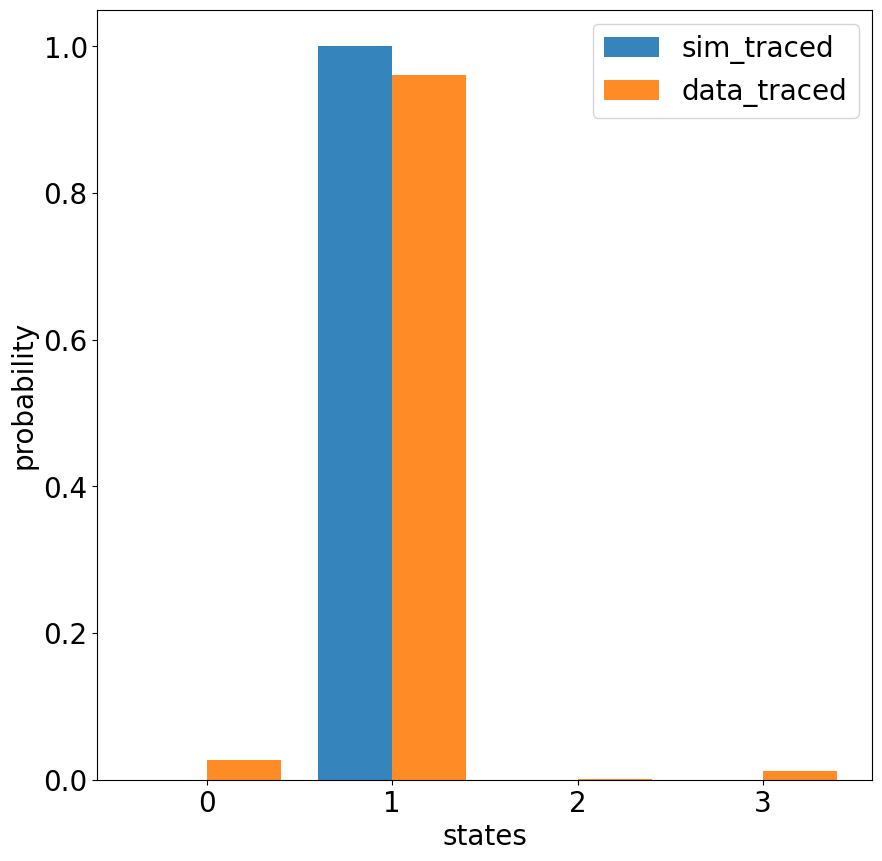

2023-10-24-162218_Line_002.txt
RY+22:RY+32:AZ3+1.0000:FTXA230.2500+:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:RY-22:RY-32



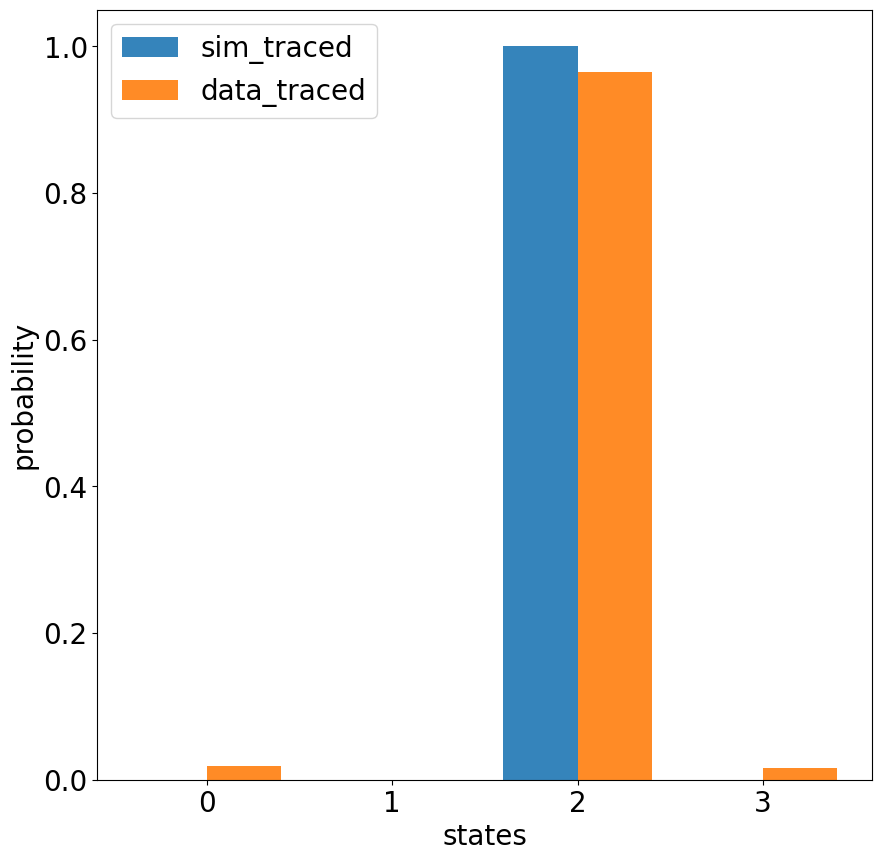

2023-10-24-162235_Line_003.txt
RY+22:RY+32:RX+21:RX+31:FTXA230.2500+:AZ2+1.0000:RY+31:FTXA230.2500+:AZ3+1.0000:RY-22:RY-32



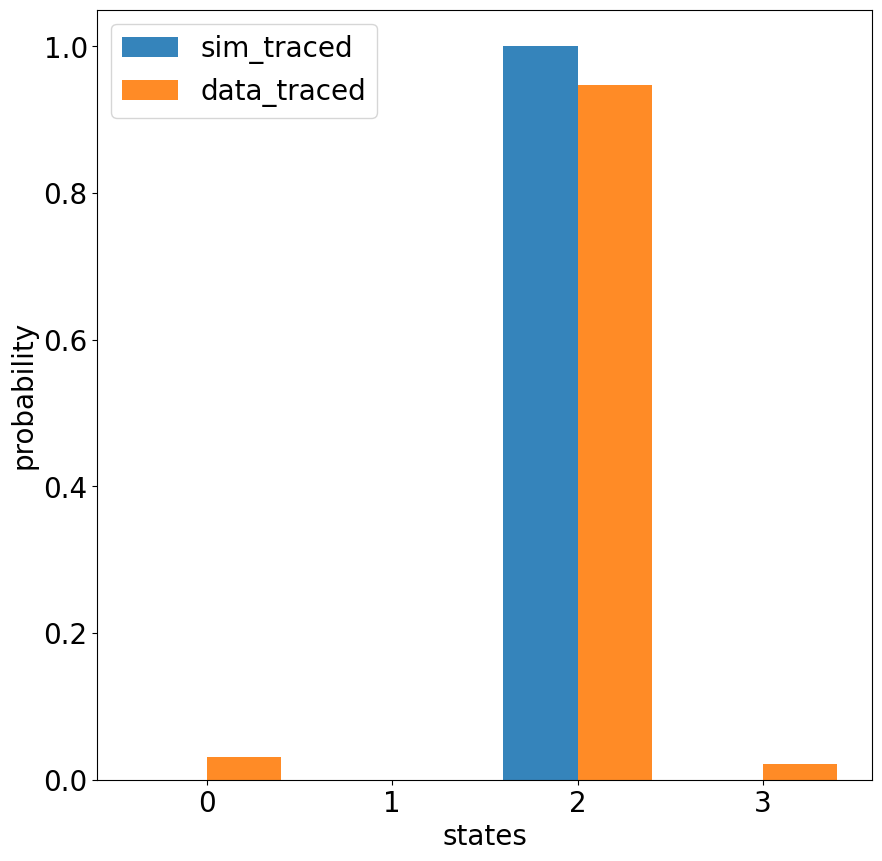

2023-10-24-162251_Line_004.txt
RY+22:RY+32:FTXA230.2500+:RX+31:FTXA230.2500+:RX+21:RY+31:RY-22:RY-32



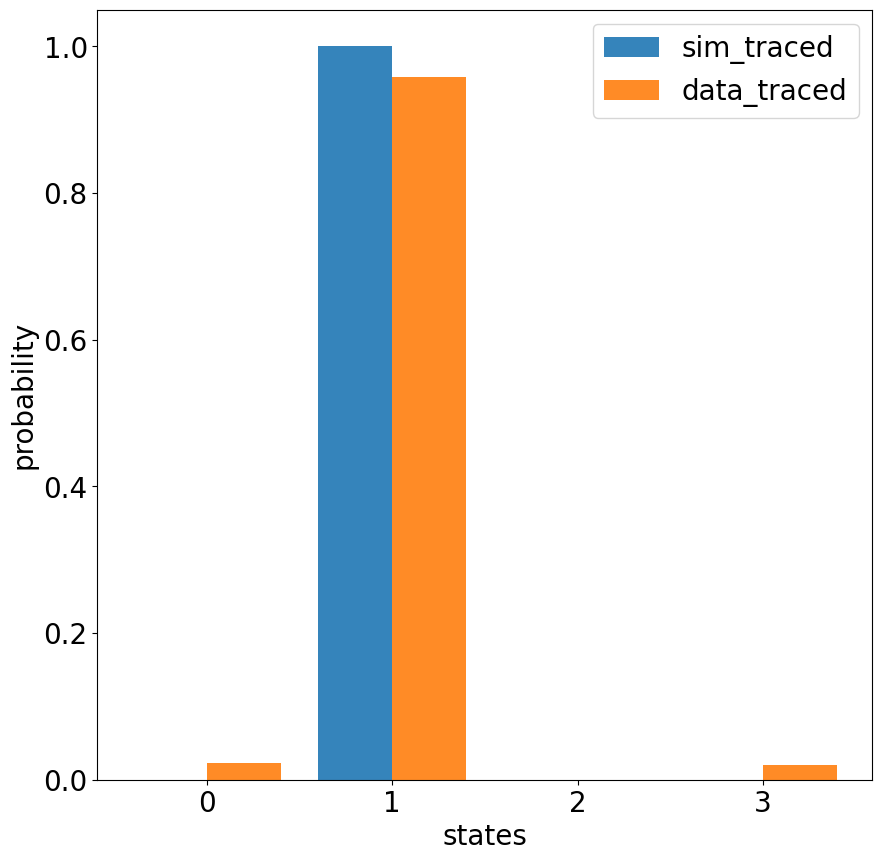

2023-10-24-162307_Line_005.txt
RY+22:RY+32:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY-22:RY-32



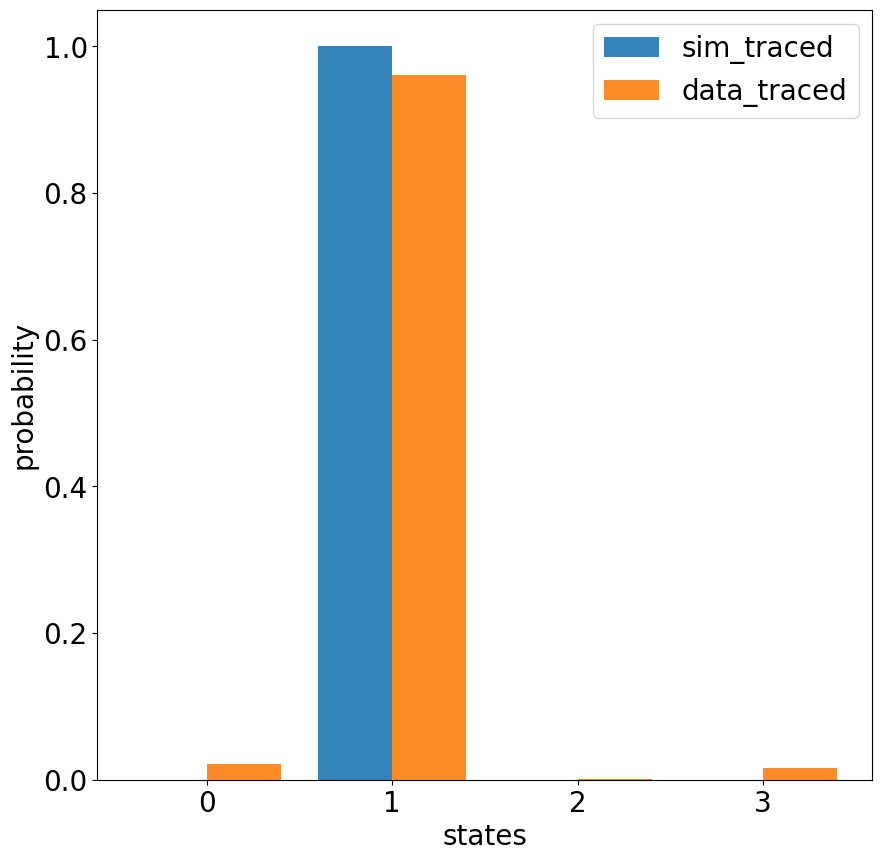

2023-10-26-144622_Line_006.txt
RY+22:RY+32:AZ2+1.0000:RY+31:FTXA230.2500+:RX+21:RY+31:FTXA230.2500+:RX+21:RY-22:RY-32



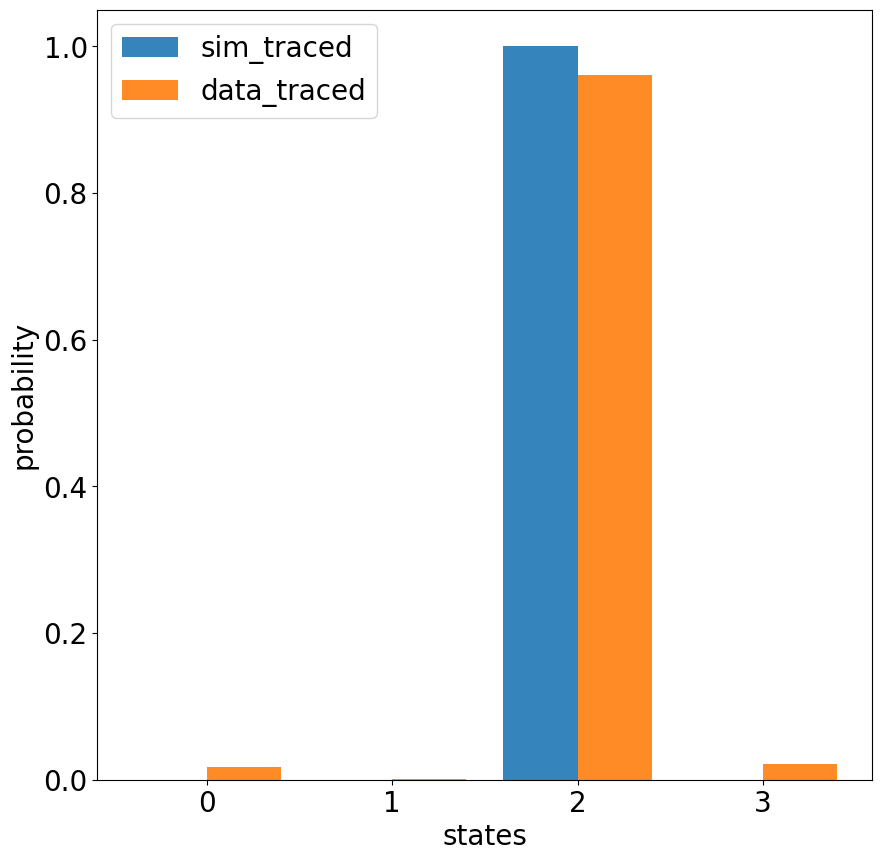

2023-10-26-144638_Line_007.txt
RY+22:RY+32:RY+31:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+31:RY-22:RY-32



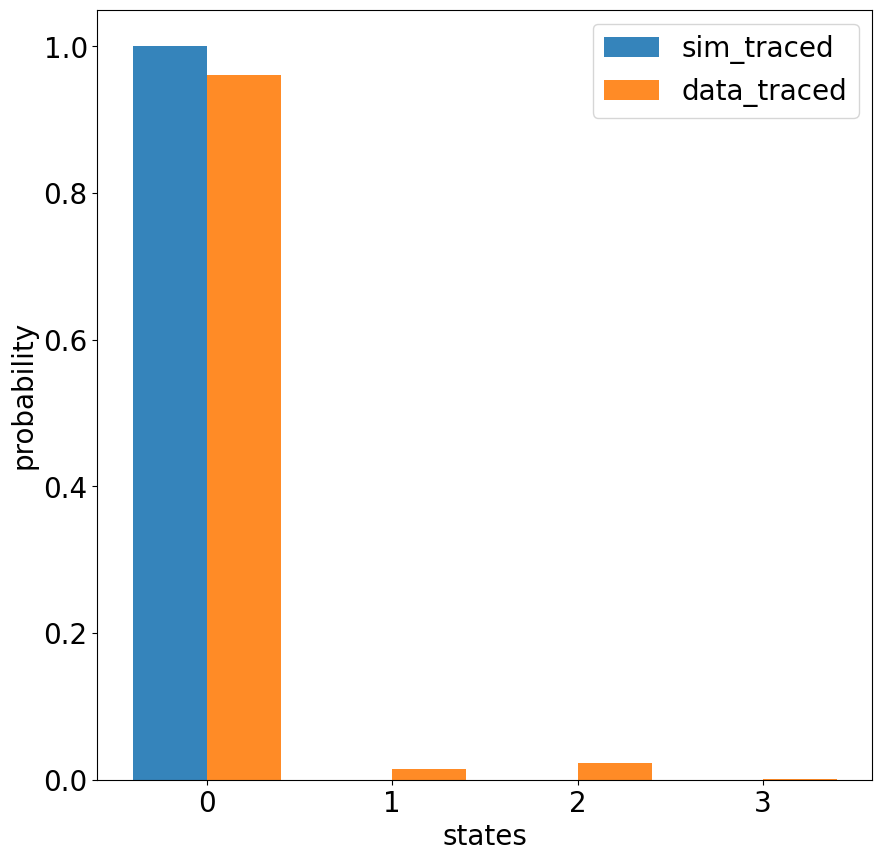

2023-10-26-144654_Line_008.txt
RY+22:RY+32:AZ3+1.0000:FTXA230.2500+:RY+21:FTXA230.2500+:AZ2+1.0000:RY-22:RY-32



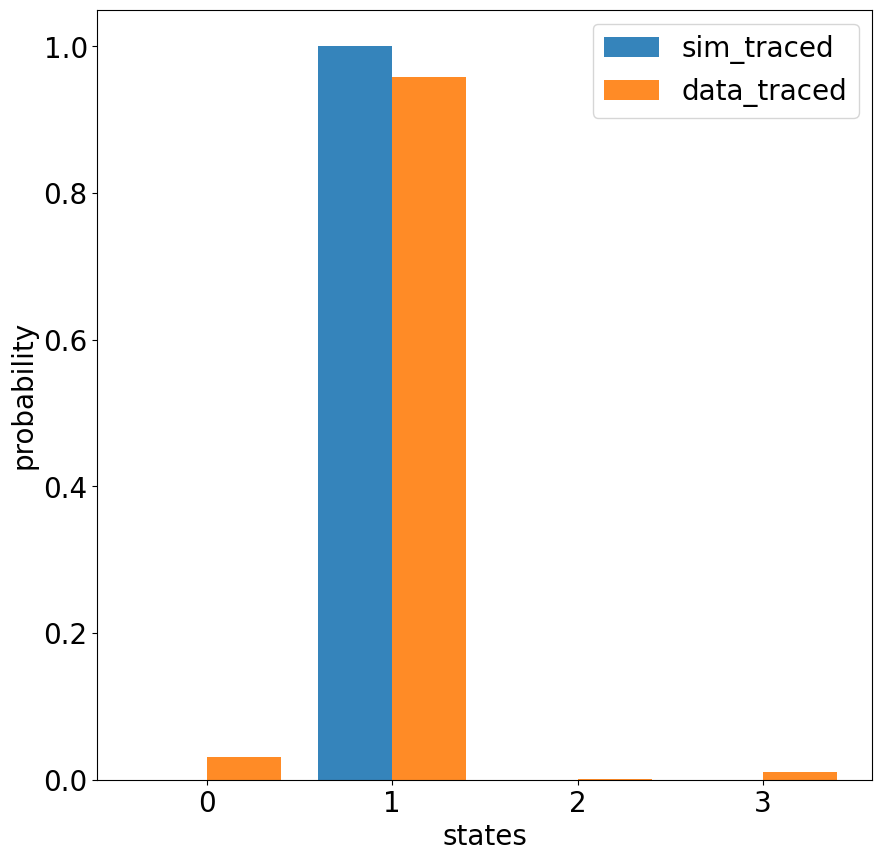

2023-10-26-144710_Line_009.txt
RY+22:RY+32:RY+21:FTXA230.2500+:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:RY-22:RY-32



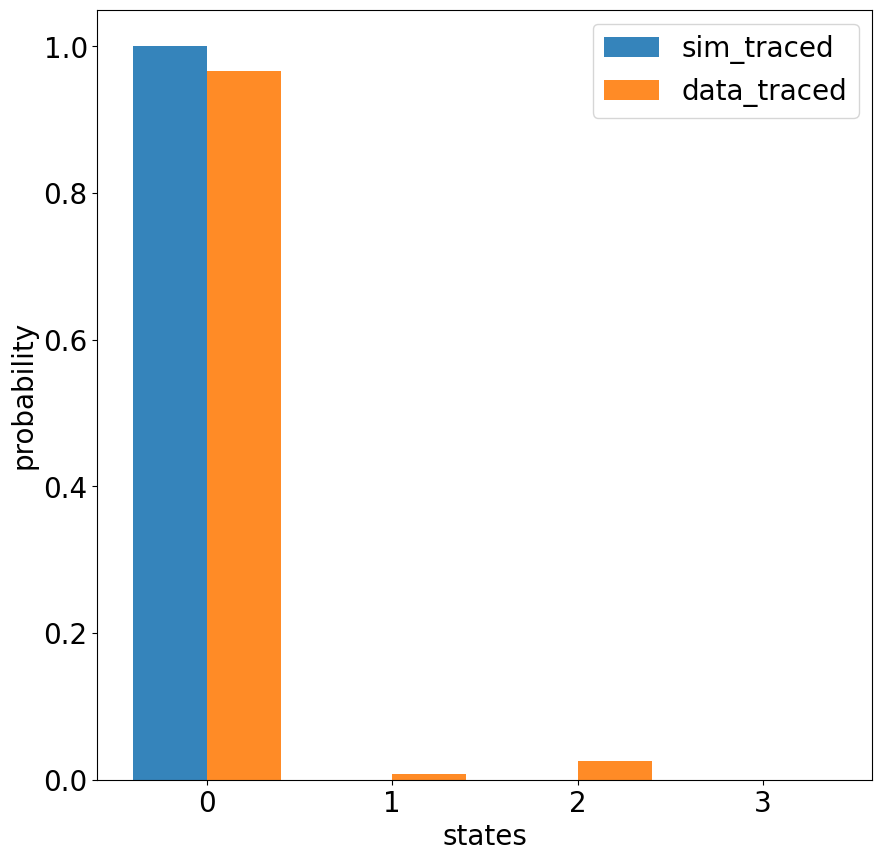

2023-10-26-144727_Line_010.txt
RY+22:RY+32:RX+21:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:RY-22:RY-32



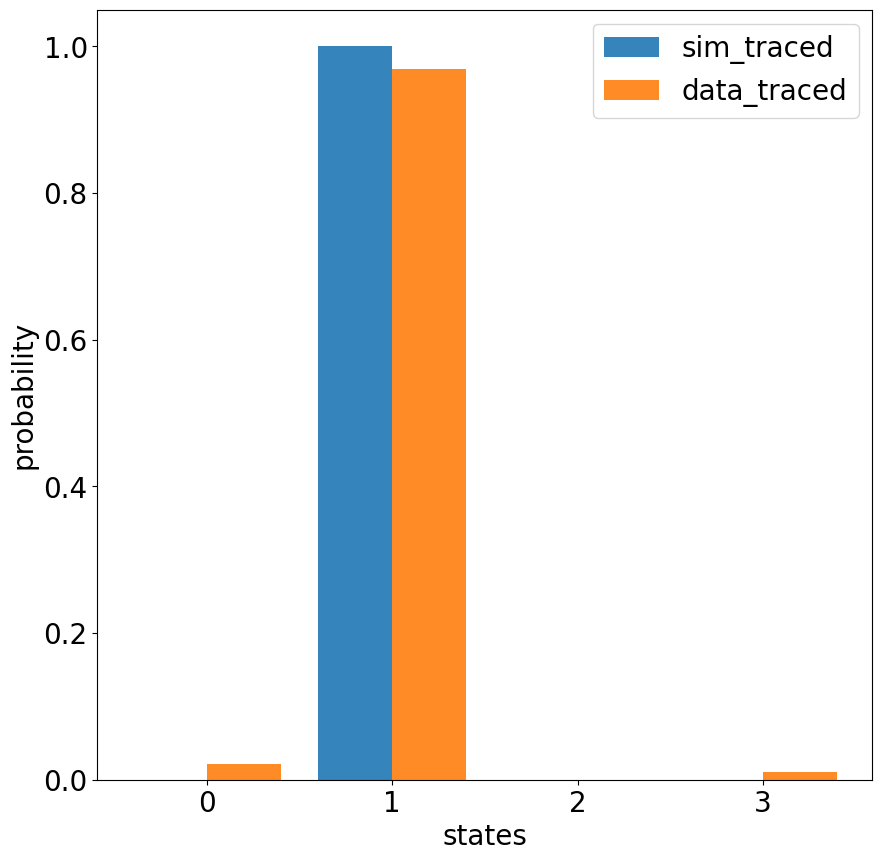

2023-10-26-200550_Line_011.txt
RY+22:RY+32:AZ2+1.0000:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RX+31:RY-22:RY-32



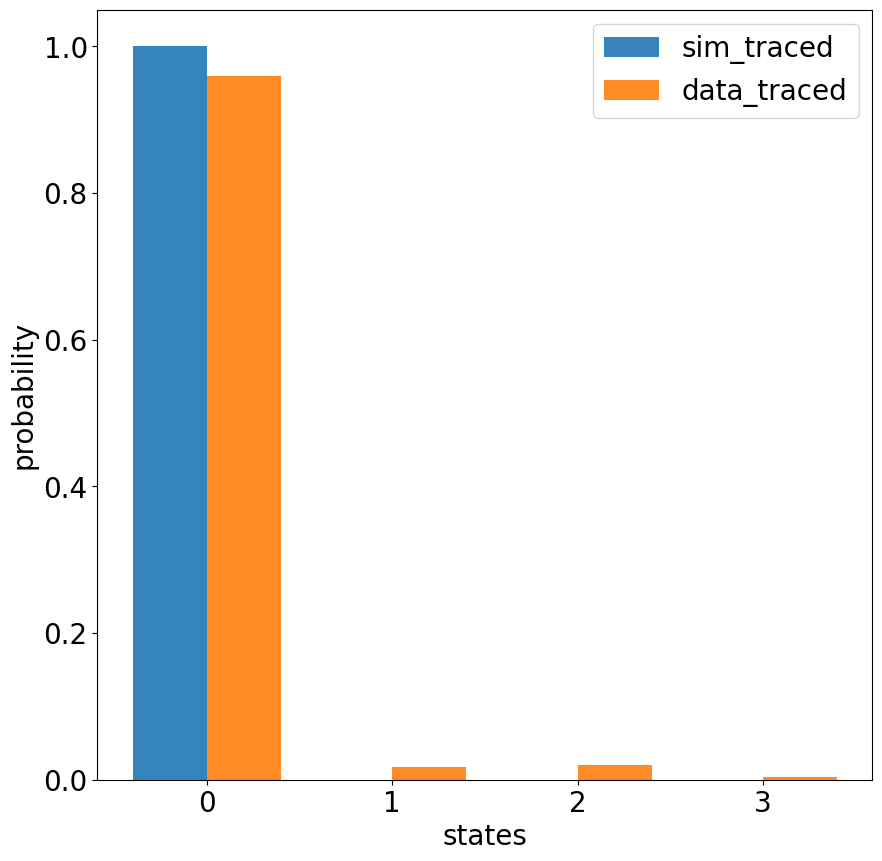

2023-10-26-200606_Line_012.txt
RY+22:RY+32:AZ2+1.0000:FTXA230.2500+:AZ3+1.0000:FTXA230.2500+:RX+21:AZ3+1.0000:RY-22:RY-32



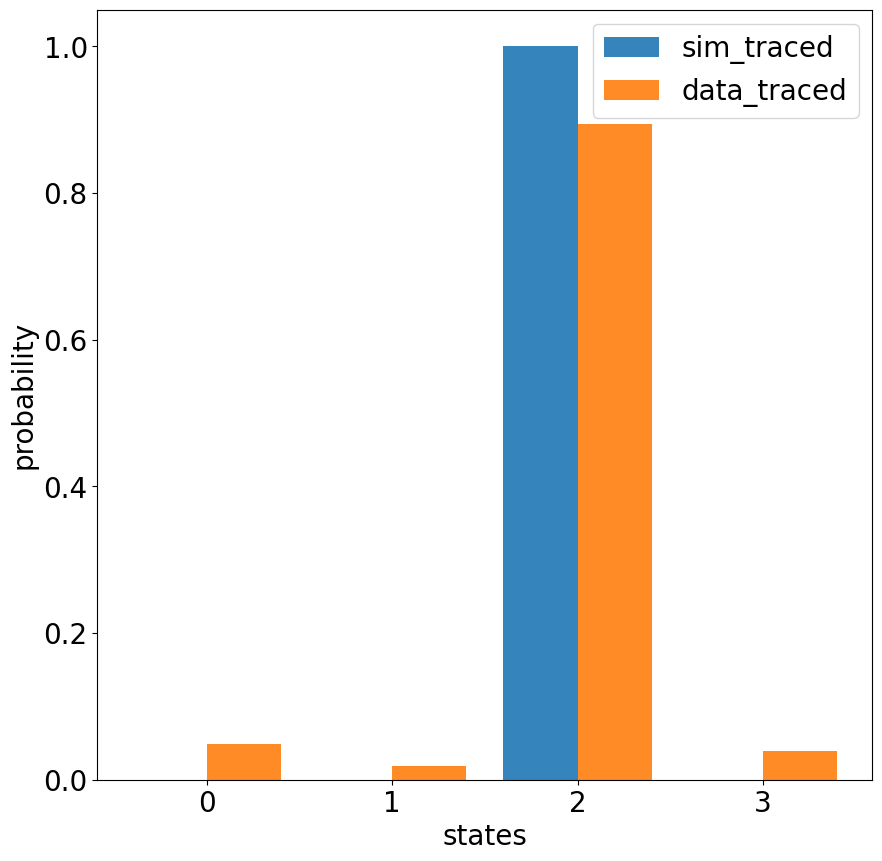

2023-10-26-200622_Line_013.txt
RY+22:RY+32:AZ3+1.0000:FTXA230.2500+:FTXA230.2500+:RY+21:RY+31:RY-22:RY-32



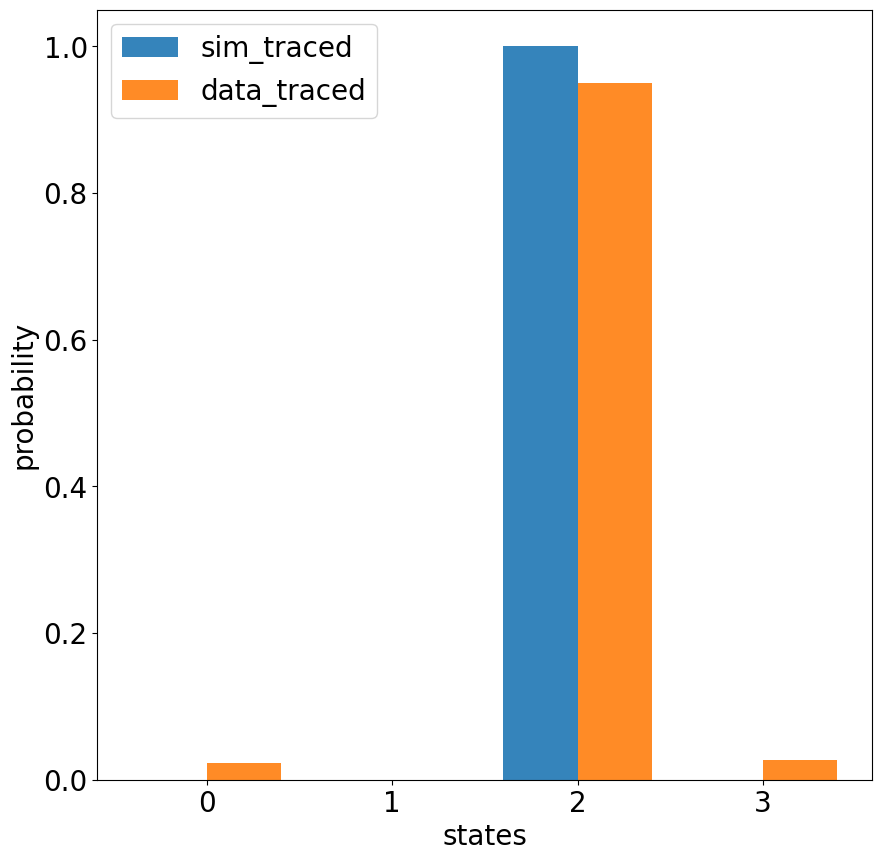

2023-10-26-200638_Line_014.txt
RY+22:RY+32:AZ3+1.0000:FTXA230.2500+:RY+31:FTXA230.2500+:RX+21:RY+31:RY-22:RY-32



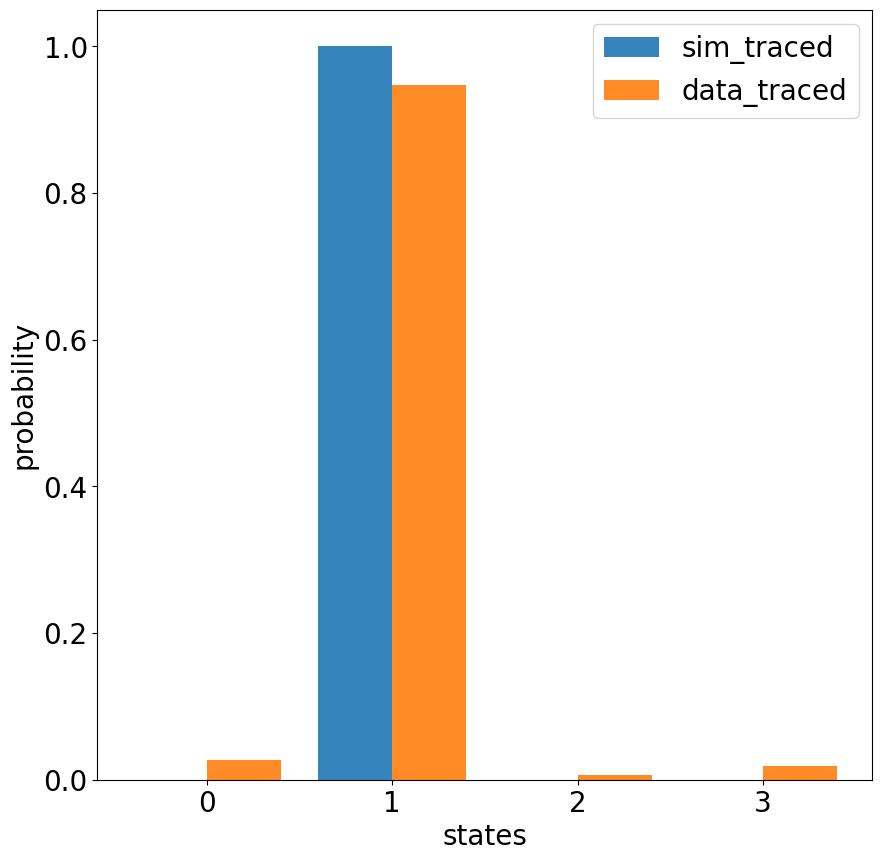

2023-10-26-200654_Line_015.txt
RY+22:RY+32:AZ3+1.0000:FTXA230.2500+:RY+21:RY+31:FTXA230.2500+:RY+31:RY-22:RY-32



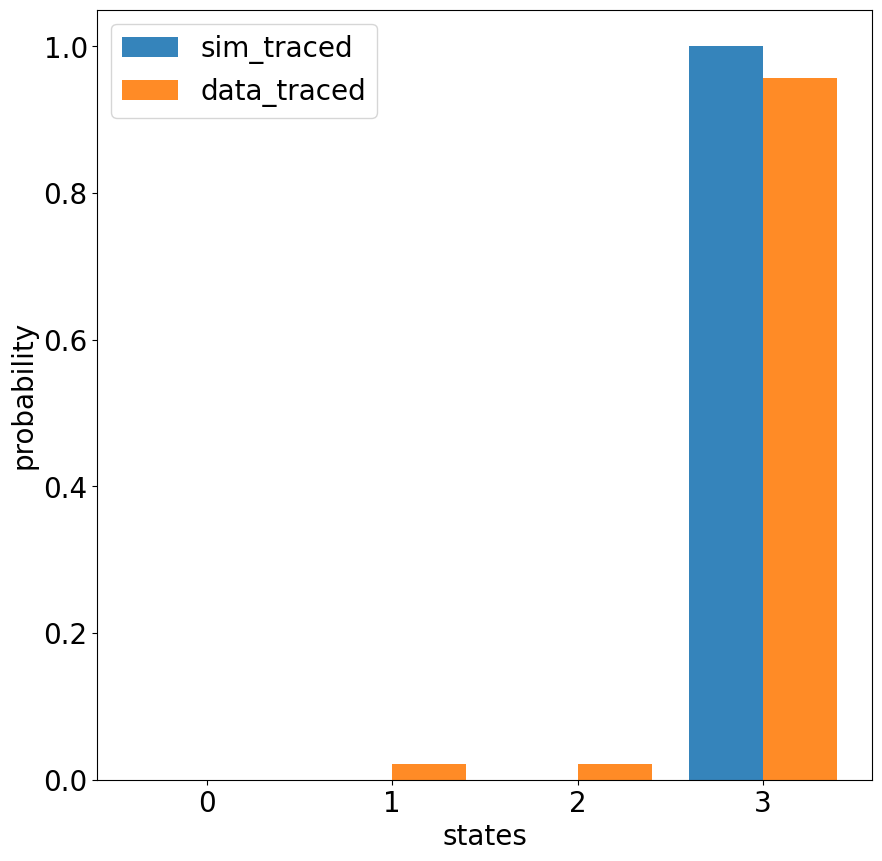

2023-10-26-200710_Line_016.txt
RY+22:RY+32:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:AZ2+1.0000:RY-22:RY-32



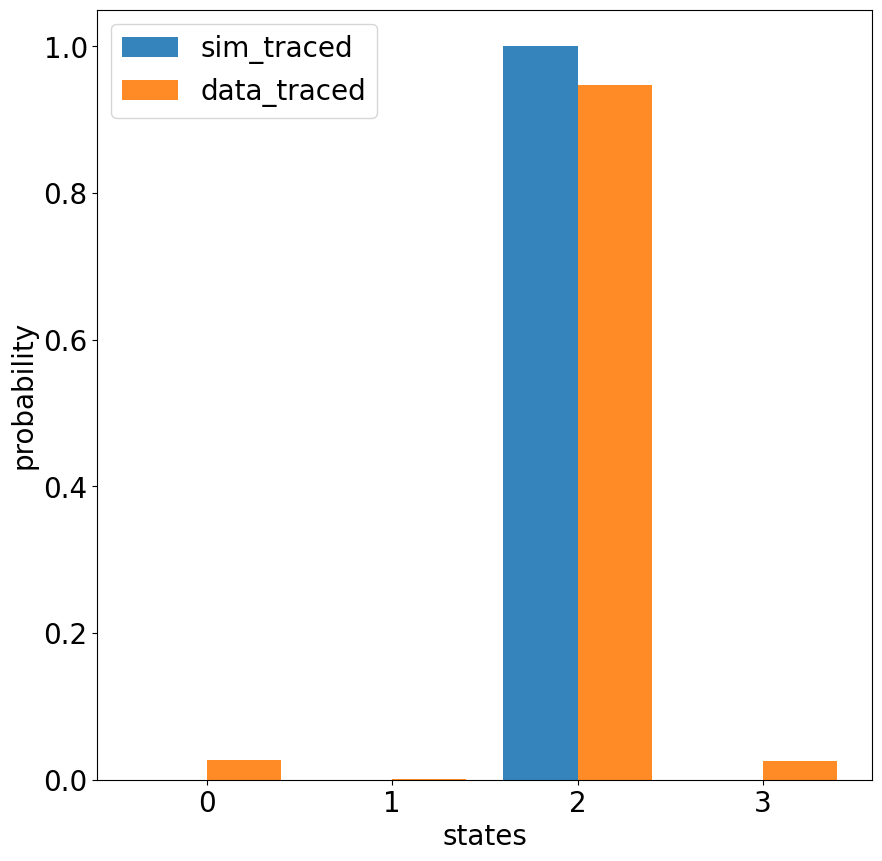

2023-10-26-200726_Line_017.txt
RY+22:RY+32:RY+21:FTXA230.2500+:AZ2+1.0000:FTXA230.2500+:RX+21:RY-22:RY-32



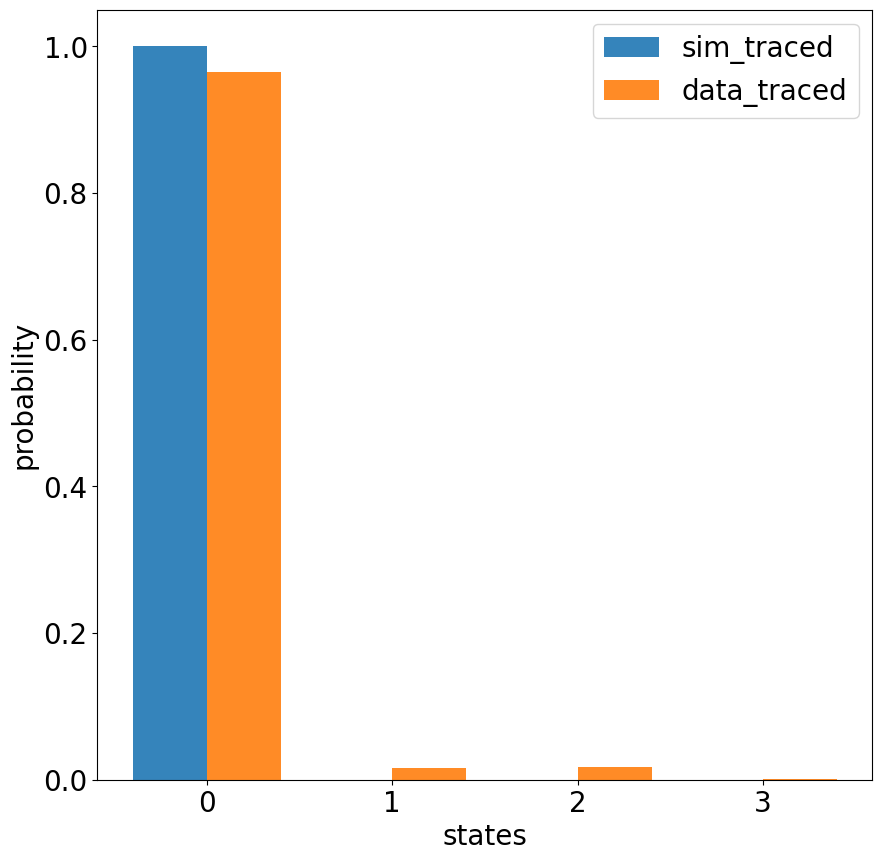

2023-10-26-200742_Line_018.txt
RY+22:RY+32:RY+21:RY+31:FTXA230.2500+:RX+31:FTXA230.2500+:AZ2+1.0000:RY-22:RY-32



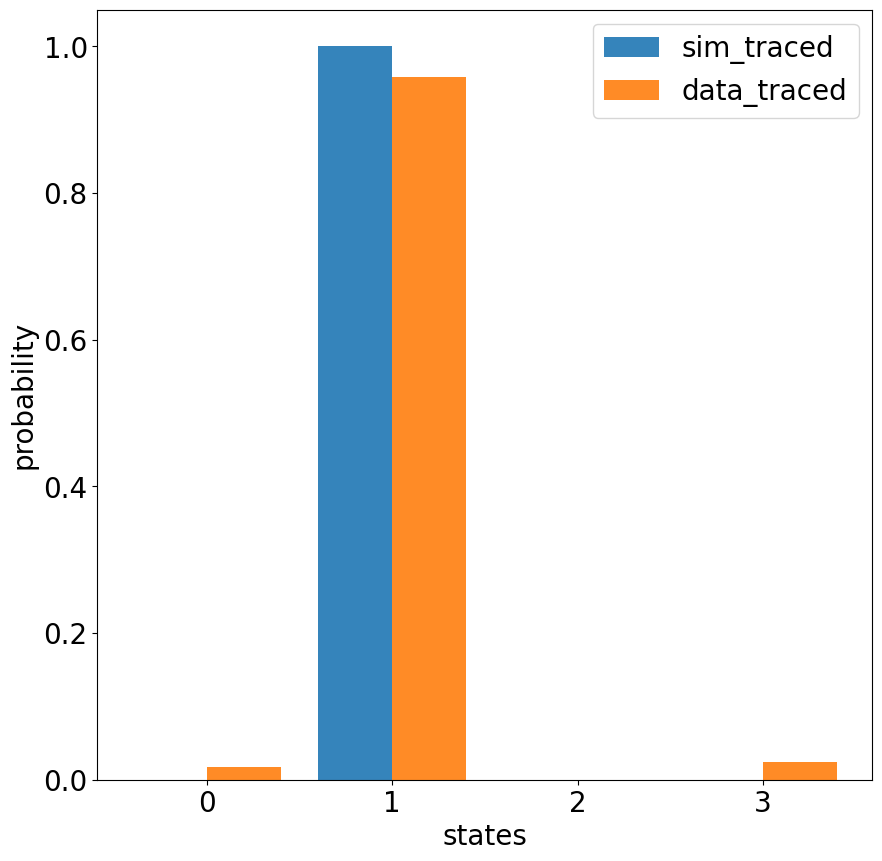

2023-10-26-200758_Line_019.txt
RY+22:RY+32:AZ2+1.0000:RX+31:FTXA230.2500+:RX+31:FTXA230.2500+:RY-22:RY-32



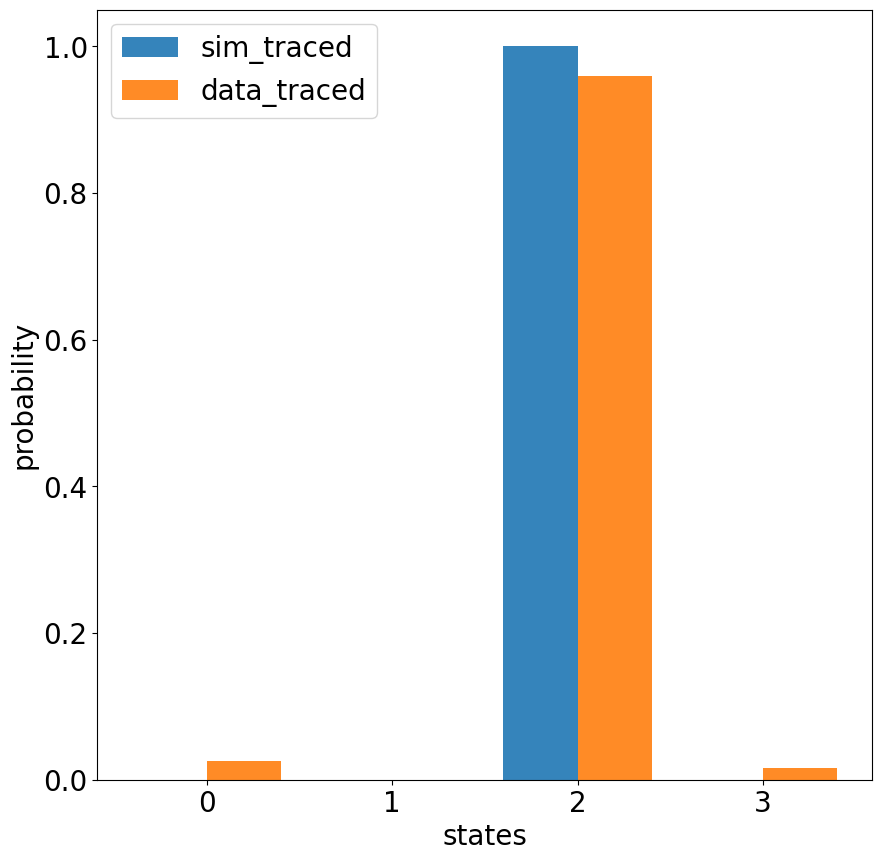

2023-10-26-200814_Line_020.txt
RY+22:RY+32:RY+21:RY+31:FTXA230.2500+:AZ2+1.0000:AZ3+1.0000:FTXA230.2500+:RY+21:RX+31:RY-22:RY-32



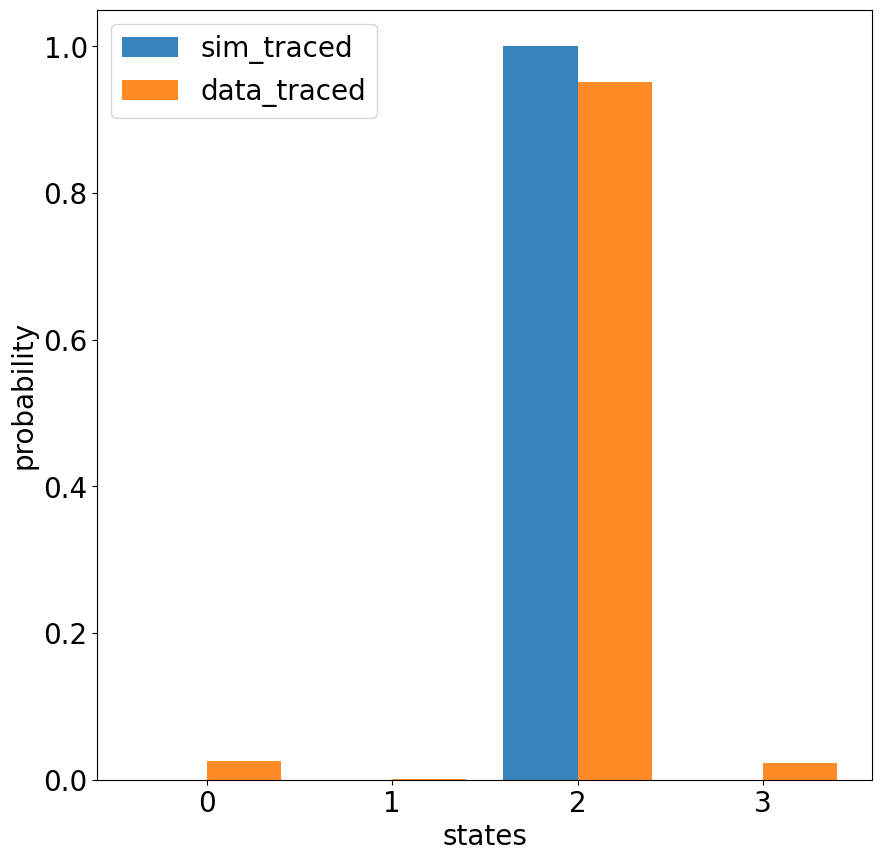

In [12]:
filenames_data=[]
circuit=[]

# counts_d2=[]
# counts_d2_spam=[]
# counts_d2_sim=[]
# shots=2000
# counts=[]
# counts_spam=[]
# counts_sim=[]

PauliLabel="XX"
DepthIndex=2
filenames_data=all_datafile_ordered[PauliLabel][DepthIndex]
# print (filenames_data)
# print (len(filenames_data))
paf_data="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023alldata/"+PauliLabel+"/"+str(DepthIndex)+"/"
circuit=all_circuits[PauliLabel][DepthIndex]


for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1])
#     counts=[round(shots*x) for x in  data_traced.population]
#     print ("counts:", counts)
#     counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
#     print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
#     counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     a_s.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_traced_spam=Trace_Out(a_s,[1,2])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)

#     a_0703.Import(paf_data_d2_0703+filenames_d2_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
#     a_rerun.Import(paf_data_d2_rerun+filenames_d2_rerun[i],keep_file=True)
#     data_rerun_traced=Trace_Out(a_rerun,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1])
#     counts_sim=[round(shots*x) for x in sim_traced.population]
#     counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
#     counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
#     Display_States_Population(states=[b,a],label=["simulation","data"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])
# #       


In [13]:
filenames_data=[]
circuit=[]

# counts_d2=[]
# counts_d2_spam=[]
# counts_d2_sim=[]
shots=2000
nqubit=2
counts=[]
# counts_spam=[]
# counts_sim=[]
all_counts={}

# paf_data="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023alldata/"
for PauliLabel in pauli_sample_list:
    all_counts[PauliLabel]={}
    for DepthIndex in depth:
        all_counts[PauliLabel][DepthIndex]=[]
        filenames_data=all_datafile_ordered[PauliLabel][DepthIndex]
        paf_data="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023alldata/"
        paf_data+=PauliLabel+"/"+str(DepthIndex)+"/"
        circuit=all_circuits[PauliLabel][DepthIndex]


        for i in range (len(filenames_data)):
            print (filenames_data[i])
            a.Import(paf_data+filenames_data[i],keep_file=True)
            data_traced=Trace_Out(a,[0,1])
            counts=[round(shots*x) for x in  data_traced.population]
            print ("counts:", counts)
            counts_ibm_mapping, counts_ibm_mapping_dic=counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping_no_ancilla(counts,nqubit)
#             print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
            all_counts[PauliLabel][DepthIndex].append(counts_ibm_mapping_dic)

        #     a_s=spam1.Correct_SPAM(a)
        #     a_s.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
        #     data_traced_spam=Trace_Out(a_s,[1,2])
        #     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
        #     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
        #     counts_d2_spam.append(counts_ibm_mapping_dic_spam)

        #     a_0703.Import(paf_data_d2_0703+filenames_d2_0703[i],keep_file=True)
        #     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

        #     a_rerun.Import(paf_data_d2_rerun+filenames_d2_rerun[i],keep_file=True)
        #     data_rerun_traced=Trace_Out(a_rerun,[0,1,2,3])

#             b_c.Interpret_GatesLab_Sequence(circuit[i])
#             print (circuit[i])
#             b=b_c.Simulate()
#             sim_traced=Trace_Out(b,[1,2])
        #     counts_sim=[round(shots*x) for x in sim_traced.population]
        #     counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
        #     counts_d2_sim.append(counts_ibm_mapping_dic_sim)


#             Display_States_Population(states=[b,a],label=["simulation","data"])
        #     Display_States_Population(states=[sim_traced,data_traced,data_0703_traced,data_rerun_traced],label=["sim_traced","data_traced","0703_traced","0711rerun"])
        # #       
print ("done")

2023-10-24-162201_Line_001.txt
counts: [54, 1922, 1, 23]
2023-10-24-162218_Line_002.txt
counts: [37, 0, 1930, 33]
2023-10-24-162235_Line_003.txt
counts: [62, 0, 1894, 44]
2023-10-24-162251_Line_004.txt
counts: [45, 1916, 0, 39]
2023-10-24-162307_Line_005.txt
counts: [43, 1922, 2, 33]
2023-10-26-144622_Line_006.txt
counts: [35, 2, 1921, 42]
2023-10-26-144638_Line_007.txt
counts: [1922, 30, 45, 3]
2023-10-26-144654_Line_008.txt
counts: [62, 1917, 1, 20]
2023-10-26-144710_Line_009.txt
counts: [1934, 16, 50, 0]
2023-10-26-144727_Line_010.txt
counts: [42, 1938, 0, 20]
2023-10-26-200550_Line_011.txt
counts: [1918, 36, 39, 7]
2023-10-26-200606_Line_012.txt
counts: [97, 37, 1789, 77]
2023-10-26-200622_Line_013.txt
counts: [46, 0, 1901, 53]
2023-10-26-200638_Line_014.txt
counts: [54, 1896, 12, 38]
2023-10-26-200654_Line_015.txt
counts: [0, 44, 42, 1914]
2023-10-26-200710_Line_016.txt
counts: [55, 1, 1894, 50]
2023-10-26-200726_Line_017.txt
counts: [1930, 32, 35, 3]
2023-10-26-200742_Line_018.tx

counts: [49, 0, 1907, 44]
2023-10-25-180134_Line_004.txt
counts: [43, 1919, 0, 38]
2023-10-25-180150_Line_005.txt
counts: [48, 1908, 0, 44]
2023-10-26-173317_Line_006.txt
counts: [48, 1, 1931, 20]
2023-10-26-173333_Line_007.txt
counts: [1928, 26, 44, 2]
2023-10-26-173349_Line_008.txt
counts: [62, 1893, 2, 43]
2023-10-26-173405_Line_009.txt
counts: [1922, 17, 61, 0]
2023-10-26-173421_Line_010.txt
counts: [28, 1931, 1, 40]
2023-10-31-130438_Line_011.txt
counts: [1934, 19, 46, 1]
2023-10-31-130454_Line_012.txt
counts: [60, 2, 1888, 50]
2023-10-31-130510_Line_013.txt
counts: [73, 14, 1864, 49]
2023-10-31-130527_Line_014.txt
counts: [47, 1915, 1, 37]
2023-10-31-130543_Line_015.txt
counts: [13, 42, 44, 1901]
2023-10-31-130559_Line_016.txt
counts: [38, 3, 1912, 47]
2023-10-31-130616_Line_017.txt
counts: [1934, 35, 29, 2]
2023-10-31-130632_Line_018.txt
counts: [41, 1918, 1, 40]
2023-10-31-130648_Line_019.txt
counts: [45, 0, 1916, 39]
2023-10-31-130704_Line_020.txt
counts: [67, 1, 1876, 56]
202

In [14]:
# filename = 'Oct2023_CB_rawdata_counts'
# token = ''.join(random.choice([str(j) for j in range(10)]) for i in range(10))
# filename += '_' + token
# with open('/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023counts/' + filename, 'wb') as outfile:
#     pickle.dump(all_counts, outfile)
# print (filename)

In [15]:
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023counts/Oct2023_CB_rawdata_counts_2428796181", "rb") as fp:   # Unpickling
    cb_counts = pickle.load(fp)


In [3]:
import copy
from copy import copy, deepcopy
import pickle
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/CB/XX 10102023/sim_cb_cnot_2023sep_9718455994", "rb") as fp:   # Unpickling
#     cb_load = pickle.load(fp)
with open("/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/CB/10102023/sim_cb_cnot_2023sep_9718455994", "rb") as fp:   # Unpickling
    cb_load = pickle.load(fp)
cb_load_cpy=deepcopy(cb_load)
# eab_load_cpy_spam=deepcopy(eab_load[0:100])
print (cb_load["XX"]["result"][21])

AttributeError: 'CircuitInstruction' object has no attribute '_legacy_format_cache'

In [ ]:
import itertools
nqubit=2
pauli_sample_list = [''.join(s) for s in itertools.product(['X','Y','Z'], repeat = nqubit)]
for PauliLabel in pauli_sample_list:
    cb_load_cpy[PauliLabel]["result"]=cb_load_cpy[PauliLabel]["result"][0:20]+cb_load_cpy[PauliLabel]["result"][40:60]+cb_load_cpy[PauliLabel]["result"][80:100]

In [ ]:
print (cb_load_cpy["XX"])

In [ ]:
C=20
depth=[2,8,32]
for PauliLabel in pauli_sample_list:
    for j in range (len(depth)):
        for i in range (C*j, C*(j+1)):
            print (cb_load_cpy[PauliLabel]["result"][i]["L"])
            if j ==0:
                assert cb_load_cpy[PauliLabel]["result"][i]["L"]==2
            if j ==1:
                assert cb_load_cpy[PauliLabel]["result"][i]["L"]==8
            if j ==2:
                assert cb_load_cpy[PauliLabel]["result"][i]["L"]==32
            print (cb_load_cpy[PauliLabel]["result"][i]["counts"])
            print (cb_counts[PauliLabel][depth[j]][i-C*j])

#             print (counts_d2[i].copy())
            print ("\n")
            cb_load_cpy[PauliLabel]["result"][i]["counts"]=cb_counts[PauliLabel][depth[j]][i-C*j]



{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 39, '10': 1937, '01': 1, '11': 23}


2
{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 1925, '10': 16, '01': 59, '11': 0}


2
{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 52, '10': 2, '01': 1898, '11': 48}


2
{'00': 0, '10': 0, '01': 0, '11': 2000}
{'00': 44, '10': 4, '01': 1913, '11': 39}


2
{'00': 0, '10': 0, '01': 0, '11': 2000}
{'00': 41, '10': 1911, '01': 1, '11': 47}


2
{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 3, '10': 43, '01': 33, '11': 1921}


2
{'00': 0, '10': 0, '01': 0, '11': 2000}
{'00': 34, '10': 1, '01': 1915, '11': 50}


2
{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 1933, '10': 30, '01': 33, '11': 4}


2
{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 40, '10': 1907, '01': 2, '11': 51}


2
{'00': 0, '10': 0, '01': 0, '11': 2000}
{'00': 58, '10': 0, '01': 1916, '11': 26}


2
{'00': 2000, '10': 0, '01': 0, '11': 0}
{'00': 51, '10': 2, '01': 1911, '11': 36}


8
{'00': 0, '10': 0, '01': 0, '11': 2000}
{'00': 1840, '

In [ ]:
filename = str(uuid.uuid4())
filename+="CB_data_processed_Oct2023_remake"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/CB/oct2023counts/"+filename, "wb") as fp:
    pickle.dump(cb_load_cpy, fp)


In [ ]:
print ("done")

Data analysis

plot average fidelity and fit

plot fidelity from each circuit and fit

data analysis with bootstrapping

spam results

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)

In [ ]:
for i in range(20,40):
    print (i)

In [ ]:
l=[1,2,3]
print (l[0:2])